In [1]:
import pyspark
from delta import *

root_path = "/Users/hamzaharunamohammed/Desktop/etiya"

builder = pyspark.sql.SparkSession.builder.appName("MyApp") \
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")

spark = configure_spark_with_delta_pip(builder).getOrCreate()

:: loading settings :: url = jar:file:/usr/local/Homebrew/Caskroom/miniforge/base/envs/delta_lake/lib/python3.9/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/hamzaharunamohammed/.ivy2/cache
The jars for the packages stored in: /Users/hamzaharunamohammed/.ivy2/jars
io.delta#delta-core_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-68ff6678-3dd1-4f85-bccd-7d4e224cb5d4;1.0
	confs: [default]
	found io.delta#delta-core_2.12;2.4.0 in central
	found io.delta#delta-storage;2.4.0 in central
	found org.antlr#antlr4-runtime;4.9.3 in central
downloading https://repo1.maven.org/maven2/io/delta/delta-core_2.12/2.4.0/delta-core_2.12-2.4.0.jar ...
	[SUCCESSFUL ] io.delta#delta-core_2.12;2.4.0!delta-core_2.12.jar (470ms)
downloading https://repo1.maven.org/maven2/io/delta/delta-storage/2.4.0/delta-storage-2.4.0.jar ...
	[SUCCESSFUL ] io.delta#delta-storage;2.4.0!delta-storage.jar (88ms)
:: resolution report :: resolve 420ms :: artifacts dl 563ms
	:: modules in use:
	io.delta#delta-core_2.12;2.4.0 from central in [default]
	io.delta#delta-storage;2.4.0 from central in [default]
	o

In [8]:
# Location variables
tripdelaysFilePath = root_path+"/delta_lake/data/departuredelays.csv" # source 1, 2

pathToEventsTable = root_path+"/delta_lake/data/deltalake/departuredelays.delta" # data lake

In [9]:
# Read flight delay data
departureDelays = spark.read \
.option("header", "true") \
.option("inferSchema", "true") \
.csv(tripdelaysFilePath)

In [10]:
departureDelays.show(5)

+-------+-----+--------+------+-----------+
|   date|delay|distance|origin|destination|
+-------+-----+--------+------+-----------+
|1011245|    6|     602|   ABE|        ATL|
|1020600|   -8|     369|   ABE|        DTW|
|1021245|   -2|     602|   ABE|        ATL|
|1020605|   -4|     602|   ABE|        ATL|
|1031245|   -4|     602|   ABE|        ATL|
+-------+-----+--------+------+-----------+
only showing top 5 rows



In [11]:
# Save flight delay data into Delta Lake format
departureDelays \
.write \
.format("delta") \
.mode("overwrite") \
.save(pathToEventsTable)

24/06/11 12:24:29 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 96.54% for 7 writers
24/06/11 12:24:29 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 84.47% for 8 writers
24/06/11 12:24:30 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 96.54% for 7 writers


In [12]:
# Load flight delay data in Delta Lake format
delays_delta = spark \
.read \
.format("delta") \
.load(pathToEventsTable)

# Create temporary view
delays_delta.createOrReplaceTempView("delays_delta")
 
# How many flights are between Seattle and San Francisco
spark.sql("select count(1) from delays_delta where origin = 'SEA' and destination = 'SFO'").show()

+--------+
|count(1)|
+--------+
|    1698|
+--------+



In [13]:
# delete our fligtb data

from delta.tables import *
from pyspark.sql.functions import *


# Access the Delta Lake table
deltaTable = DeltaTable.forPath(spark, pathToEventsTable)


# Delete all flight on-time and early flights
deltaTable.delete("delay < 0")

24/06/11 12:30:11 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 96.54% for 7 writers
24/06/11 12:30:12 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 84.47% for 8 writers
24/06/11 12:30:13 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 96.54% for 7 writers


In [14]:
deltaTable.toDF().show(5)

+-------+-----+--------+------+-----------+
|   date|delay|distance|origin|destination|
+-------+-----+--------+------+-----------+
|1201755|    0|     449|   ORF|        ATL|
|1201610|   52|     449|   ORF|        ATL|
|1201441|    0|     449|   ORF|        ATL|
|1210700|    5|     449|   ORF|        ATL|
|1211243|    2|     449|   ORF|        ATL|
+-------+-----+--------+------+-----------+
only showing top 5 rows



In [15]:
# Update our Flight Data


# Update all flights originating from Detroit to now be originating from Seattle
deltaTable.update("origin = 'DTW'", { "origin": "'SEA'" } ) 


# How many flights are between Seattle and San Francisco
spark.sql("select count(1) from delays_delta where origin = 'SEA' and destination = 'SFO'").show()

+--------+
|count(1)|
+--------+
|     986|
+--------+



In [16]:
# Merge our Flight Data

# What flights between SEA and SFO for these date periods
spark.sql("select * from delays_delta where origin = 'SEA' and destination = 'SFO' and date like '1010%' limit 10").show()

+-------+-----+--------+------+-----------+
|   date|delay|distance|origin|destination|
+-------+-----+--------+------+-----------+
|1010710|   31|     590|   SEA|        SFO|
|1010521|    0|     590|   SEA|        SFO|
|1010955|  104|     590|   SEA|        SFO|
|1010730|    5|     590|   SEA|        SFO|
+-------+-----+--------+------+-----------+



In [17]:
# generate our own merge_table that contains data we will insert into our delta table

items = [(1010710, 31, 590, 'SEA', 'SFO'),
          (1010521, 10, 590, 'SEA', 'SFO'), 
          (1010822, 31, 590, 'SEA', 'SFO')]



cols = ['date', 'delay', 'distance', 'origin', 'destination']
merge_table = spark.createDataFrame(items, cols)
merge_table.toPandas()

,date,delay,distance,origin,destination
0,1010710,31,590,SEA,SFO
1,1010521,10,590,SEA,SFO
2,1010822,31,590,SEA,SFO


In [18]:
# Merge merge_table with flights
deltaTable.alias("flights") \
    .merge(merge_table.alias("updates"),"flights.date = updates.date") \
    .whenMatchedUpdate(set = { "delay" : "updates.delay" } ) \
    .whenNotMatchedInsertAll() \
    .execute()

# What flights between SEA and SFO for these date periods
spark.sql("select * from delays_delta where origin = 'SEA' and destination = 'SFO' and date like '1010%' limit 10").show()

+-------+-----+--------+------+-----------+
|   date|delay|distance|origin|destination|
+-------+-----+--------+------+-----------+
|1010521|   10|     590|   SEA|        SFO|
|1010710|   31|     590|   SEA|        SFO|
|1010955|  104|     590|   SEA|        SFO|
|1010730|    5|     590|   SEA|        SFO|
+-------+-----+--------+------+-----------+



In [19]:
# View Table History
deltaTable.history().show()

+-------+--------------------+------+--------+---------+--------------------+----+--------+---------+-----------+--------------+-------------+--------------------+------------+--------------------+
|version|           timestamp|userId|userName|operation| operationParameters| job|notebook|clusterId|readVersion|isolationLevel|isBlindAppend|    operationMetrics|userMetadata|          engineInfo|
+-------+--------------------+------+--------+---------+--------------------+----+--------+---------+-----------+--------------+-------------+--------------------+------------+--------------------+
|      3|2024-06-11 12:35:...|  NULL|    NULL|    MERGE|{predicate -> ["(...|NULL|    NULL|     NULL|          2|  Serializable|        false|{numTargetRowsCop...|        NULL|Apache-Spark/3.5....|
|      2|2024-06-11 12:30:...|  NULL|    NULL|   UPDATE|{predicate -> ["(...|NULL|    NULL|     NULL|          1|  Serializable|        false|{numRemovedFiles ...|        NULL|Apache-Spark/3.5....|
|      1|2

In [20]:
# you can use same using SQL
spark.sql("DESCRIBE HISTORY '" + pathToEventsTable + "'").show()

+-------+--------------------+------+--------+---------+--------------------+----+--------+---------+-----------+--------------+-------------+--------------------+------------+--------------------+
|version|           timestamp|userId|userName|operation| operationParameters| job|notebook|clusterId|readVersion|isolationLevel|isBlindAppend|    operationMetrics|userMetadata|          engineInfo|
+-------+--------------------+------+--------+---------+--------------------+----+--------+---------+-----------+--------------+-------------+--------------------+------------+--------------------+
|      3|2024-06-11 12:35:...|  NULL|    NULL|    MERGE|{predicate -> ["(...|NULL|    NULL|     NULL|          2|  Serializable|        false|{numTargetRowsCop...|        NULL|Apache-Spark/3.5....|
|      2|2024-06-11 12:30:...|  NULL|    NULL|   UPDATE|{predicate -> ["(...|NULL|    NULL|     NULL|          1|  Serializable|        false|{numRemovedFiles ...|        NULL|Apache-Spark/3.5....|
|      1|2

In [ ]:
# Travel Back in Time with Table History
# Load DataFrames for each version
dfv0 = spark.read.format("delta").option("versionAsOf", 0).load(pathToEventsTable)
dfv1 = spark.read.format("delta").option("versionAsOf", 1).load(pathToEventsTable)
dfv2 = spark.read.format("delta").option("versionAsOf", 2).load(pathToEventsTable)

# Calculate the SEA to SFO flight counts for each version of history
cnt0 = dfv0.where("origin = 'SEA'").where("destination = 'SFO'").count()
cnt1 = dfv1.where("origin = 'SEA'").where("destination = 'SFO'").count()
cnt2 = dfv2.where("origin = 'SEA'").where("destination = 'SFO'").count()

# Print out the value
print("SEA -> SFO Counts: Create Table: %s, Delete: %s, Update: %s" % (cnt0, cnt1, cnt2))


In [ ]:
# Remove all files older than 0 hours old.
#deltaTable.vacuum(0)

In [ ]:
columns = ["id", "data_id"]


data  = [1, "data_id",
         2, "data_id",
         3, "data_id",
         ]

df = spark.createDataFrame(data, columns)

df.write.format("delta").mode("overwrite").save("/tmp/delta-table")



df.write.format("delta").partitionBy("data_id").mode("overwrite").save("/tmp/delta-table")

In [ ]:
# no partition
deltaTable = DeltaTable.forPath(spark, "parquat", '/tmp/delta-table')


# with patition
partion_delata_table = DeltaTable.forPath(spark, "parquat", '/tmp/delta-table', "part int")

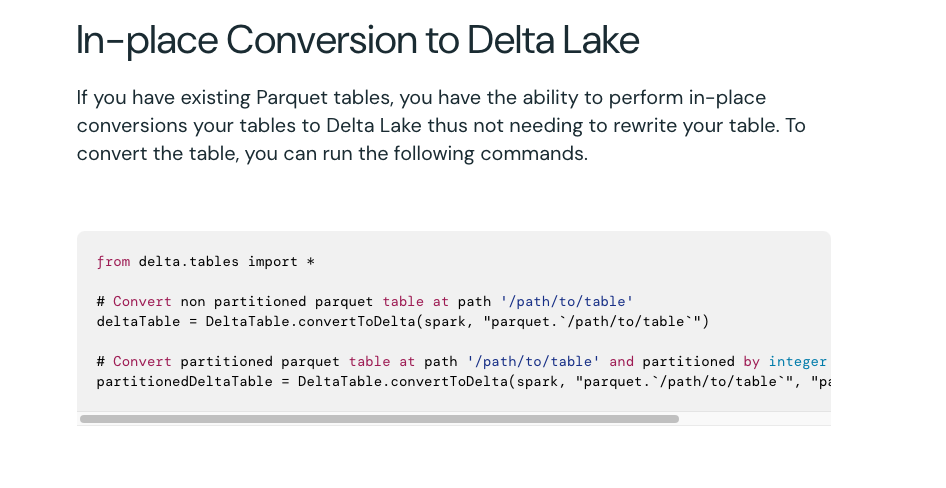